In [1]:
"""
This notebook reads CALIPSO and GEOSCCM convective cloud ice data.
We get the ice in pressure-latitude domain
and in latitude-longitude domain
during December-January-Febuary (DJF) and June-July-August (JJA).
Then we plot the data.
"""

'\nThis notebook reads CALIPSO and GEOSCCM convective cloud ice data.\nWe get the ice in pressure-latitude domain\nand in latitude-longitude domain\nduring December-January-Febuary (DJF) and June-July-August (JJA).\nThen we plot the data.\n'

In [1]:
import numpy as np
import pandas as pd
import xarray as xr 
from seasonal_cycle_analysis_functions import *
import matplotlib.pyplot as plt
%matplotlib inline
degree_sign= u'\N{DEGREE SIGN}'
from string import ascii_lowercase
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read data

In [2]:
indir = '/mnt/data/ice2/xwang/ACP2019_data_code/data/'

#--- Read CALIPSO convective ice data
ff = xr.open_dataset(indir+'calipso_convective_IWC.nc')
ff['time']=pd.to_datetime(ff.time, format='%Y%m')
#--- use total iwc minus the cirrus cloud ice
conv = (ff.totiwcvmr-ff.ciiwcvmr).sel(pressure=slice(150,50)).groupby('time.season').mean(dim='time')
#--- get the pressure-latitude JJA and DJF data
cal_zonal = conv.mean(dim='longitude').sel(season=['JJA','DJF']).values
#--- get the latitude-longitude JJA and DJF data between 121-82 hPa
cal_hor = conv.sel(pressure=slice(122,80)).mean(dim='pressure').sel(season=['JJA','DJF']).values

cal_lat = ff.latitude.values
cal_lon = ff.longitude.values
cal_pr = ff.pressure.sel(pressure=slice(150,50)).values
ff.close()

#--- Read GEOSCCM convective ice data
ff = xr.open_dataset(indir+'geosccm_icemix.nc')
ff['time']=pd.to_datetime(ff.time, format='%Y%m')
ff = ff.sel(time=slice('2008-05-01','2013-12-31'))
geos_ice = ff.ice_mix.sel(pressure=slice(150,50)).groupby('time.season').mean(dim='time').sel(season=['JJA','DJF'])
#--- get the pressure-latitude JJA and DJF data
geos_zonal = geos_ice.mean(dim='longitude').values
#--- append the 0.2ice data
geos_zonal = np.append(geos_zonal[np.newaxis,:],geos_zonal[np.newaxis,:]*0.2,axis=0)
#--- get the latitude-longitude JJA and DJF data between 121-82 hPa
geos_hor = geos_ice.sel(pressure=slice(122,80)).mean(dim='pressure').values
#--- append the 0.2ice data
geos_hor = np.append(geos_hor[np.newaxis,:],geos_hor[np.newaxis,:]*0.2,axis=0)

geos_lat = ff.latitude.values
geos_lon = ff.longitude.values
geos_pr = ff.pressure.sel(pressure=slice(150,50)).values
ff.close()

/usr/local/anaconda/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Begin plotting Figures

In [3]:
#--- pre-define some variables to aid the plotting

title = ['CALIOP','GEOSCCM','GEOSCCM 0.2ice']
titley = ['JJA','DJF']
llabel = ['a','c','e','b','d','f']
prtk = [146,121,100,82,68]
lattick1 = np.array([-90,-60,-30,0,30,60,90])
lattick2 = [-40,-20,0,20,40]
lontick = [0,120,240,360]
cticks1 = [0,0.01,0.05,0.2,0.4,1.0,2.5,4.0,8.,10.,12.]
cticks2 = [0,0.01,0.05,0.2,0.4,1.0,2.5,4,8]

prstr = np.array([str(i) for i in prtk])
latstr = ['40'+degree_sign+' S','20'+degree_sign+' S','0','20'+degree_sign+' N','40'+degree_sign+' N']
lonstr = ['0'+degree_sign+' E','120'+degree_sign+' E','240'+degree_sign+' E','360'+degree_sign+' E']



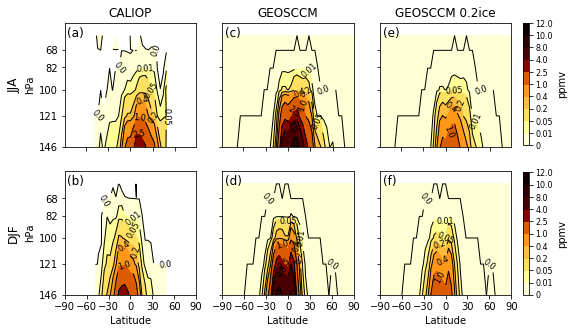

In [4]:
fig,ax = plt.subplots(nrows=2,ncols=3,sharey=True,sharex=True)
fig.set_size_inches(8,5, forward=True)

cby = [0.125,0.54]


levels = np.array([0,1e-2,5*1e-2,0.2,0.4,1.,2.5,4.,8,10.,12.]) # define contour levels for the ice data
fmt = {}
strs = np.array([np.str(round(i,4)) for i in levels])          # define contour levels for the ice data
for l,s in zip(levels,strs):
    fmt[l] = s
levels2 = np.array([0,1e-3,1e-2,2*1e-2,4*1e-2,0.1,0.2,0.4,\
                    0.8,1.,2.,2.5,3.,3.5,4.,8.,10,12.])        # define contour levels for the ice data
                                                               # not all contour levels are labeled
     

k = 0
for i in range(2):
    
    ima=ax[i][0].contourf(cal_lat,cal_pr,cal_zonal[i,:],levels=levels,\
                          cmap='afmhot_r',norm=PiecewiseNorm(levels2)) # plot calipso ice
    cs=ax[i][0].contour(cal_lat,cal_pr,cal_zonal[i,:],levels=levels,\
                        linewidths=1,colors='k')                       
    ax[i][0].clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=8)       # insert labels in te contour
    
    ax[i][0].annotate(titley[i],xy=(-0.34,0.5),xycoords='axes fraction',\
                      size=12,ha='right',va='center',rotation=90)      # insert titles, labels, etc.
    ax[i][0].annotate('('+llabel[k]+')',xy=(0.02,0.97),\
                          xycoords='axes fraction',size=12,ha='left',va='top')
    ax[i][0].set_ylabel('hPa')
    ax[i][0].set_yticks(prtk) 
    ax[i][0].set_yticklabels(prstr)    


    k += 1
    for j in range(1,3):
        ima=ax[i][j].contourf(geos_lat,geos_pr,geos_zonal[j-1,i,:],levels=levels,\
                              cmap='afmhot_r',norm=PiecewiseNorm(levels2))     # plot geosccm ice
        cs=ax[i][j].contour(geos_lat,geos_pr,geos_zonal[j-1,i,:],levels=levels,\
                            linewidths=1,colors='k')
        ax[i][j].clabel(cs,cs.levels,inline=True,fmt=fmt,fontsize=8)           # insert labels in te contour     
        ax[i][j].annotate('('+llabel[k]+')',xy=(0.02,0.97),\
                          xycoords='axes fraction',size=12,ha='left',va='top') # insert titles, labels, etc.
        ax[i][j].set_yticks(prtk) 
        ax[i][j].set_yticklabels(prstr)
        k += 1
    cbaxes = fig.add_axes([0.92,cby[i],0.01,0.34])                             # setup colorbar
    cc = fig.colorbar(ima, ax=ax[i][-1],cax=cbaxes)    
    cc.set_ticks(cticks1)
    clabels = np.array([np.str(round(i,3)) for i in cticks1])
    cc.set_ticklabels(clabels)
    cc.ax.tick_params(labelsize=8) 
    cc.set_label('ppmv',fontsize=10) 


ax[1][-1].set_ylim([146,46])  # set up pressure level upper/lower limits       
for i in range(3):
    ax[1][i].set_xticks(lattick1)
    ax[0][i].set_title(title[i])
    ax[-1][i].set_xlabel('Latitude')
    


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


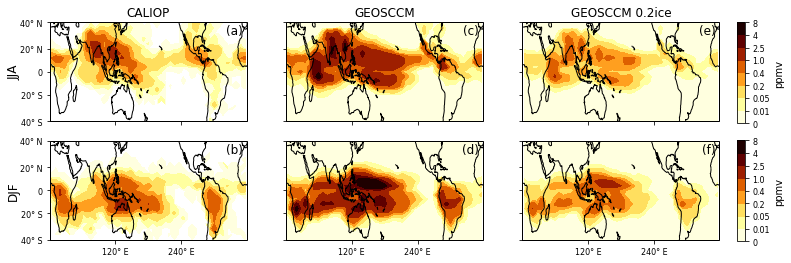

In [5]:
proj = ccrs.Mercator(central_longitude=180)

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig,ax = plt.subplots(nrows=2,ncols=3,sharey=True,sharex=True,subplot_kw={'projection': proj})
fig.set_size_inches(12,4, forward=True)


cby = [0.53,0.12]
levels = np.array([0,0.01,0.05,0.2,0.4,1.0,2.5,4,8])  # define contour levels for the ice data

k = 0
for i in range(2):
    
    ax[i][0].set_aspect('auto')  
    ima1 = ax[i][0].contourf(cal_lon,cal_lat,cal_hor[i,:],\
                             cmap='afmhot_r',levels=levels,\
                             norm=PiecewiseNorm(levels),\
                             transform=ccrs.PlateCarree())  # plot calipso ice
    ax[i][0].coastlines()                                   # plot coastlines, set up labels, ticks, etc.
    ax[i][0].xaxis.set_major_formatter(lon_formatter)
    ax[i][0].yaxis.set_major_formatter(lat_formatter)
    ax[i][0].set_yticks(lattick2,crs=ccrs.PlateCarree())
    ax[i][0].set_yticklabels(latstr,fontsize=8)
    ax[i][0].set_xticks(lontick,crs=ccrs.PlateCarree())
    ax[i][0].set_xticklabels(lonstr,fontsize=8)
    ax[i][0].set_extent([1,359,-40,40],crs=ccrs.PlateCarree())
    ax[i][0].annotate('('+llabel[k]+')',xy=(0.98,0.98),\
                          xycoords='axes fraction',size=12,ha='right',va='top')
    ax[i][0].annotate(titley[i],xy=(-0.15,0.5),xycoords='axes fraction',\
                      size=12,ha='right',va='center',rotation=90)    
    k+=1
    for j in range(1,3):
        ax[i][j].set_aspect('auto')  
        ima = ax[i][j].contourf(geos_lon,geos_lat,geos_hor[j-1,i,:],\
                                cmap='afmhot_r',levels=levels,\
                                norm=PiecewiseNorm(levels),\
                                transform=ccrs.PlateCarree()) # plot geosccm ice
        ax[i][j].coastlines()                                 # plot coastlines, set up labels, ticks, etc.
        ax[i][j].xaxis.set_major_formatter(lon_formatter)
        ax[i][j].yaxis.set_major_formatter(lat_formatter)
        ax[i][j].set_yticks(lattick2,crs=ccrs.PlateCarree())
        ax[i][j].set_yticklabels(latstr,fontsize=8)
        ax[i][j].set_xticks(lontick,crs=ccrs.PlateCarree())
        ax[i][j].set_xticklabels(lonstr,fontsize=8)
        ax[i][j].set_extent([1,359,-40,40],crs=ccrs.PlateCarree())

        ax[i][j].annotate('('+llabel[k]+')',xy=(0.98,0.98),\
                          xycoords='axes fraction',size=12,ha='right',va='top')
        k+=1
    cbaxes = fig.add_axes([0.92,cby[i],0.01,0.35])           # setup colorbars
    cc = fig.colorbar(ima, ax=ax[i][-1],cax=cbaxes)    
    cc.set_ticks(cticks2)
    clabels = np.array([np.str(round(i,3)) for i in cticks2])
    cc.set_ticklabels(clabels)
    cc.ax.tick_params(labelsize=8) 
    cc.set_label('ppmv',fontsize=10) 
plt.tight_layout(w_pad=6)

for i in range(3):
    ax[0][i].set_title(title[i])
